In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader

In [2]:
#导入train数据
a=np.load("train_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
train_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("train_label.npy").reshape(-1,1)
train_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [3]:
#导入valid数据
a=np.load("valid_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
valid_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("valid_label.npy").reshape(-1,1)
valid_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [4]:
train_data=np.transpose(train_data,(0,2,1))
valid_data=np.transpose(valid_data,(0,2,1))

In [34]:
train_data.shape

(42531, 42, 10)

In [5]:
def predict_precision(model,images,labels,device,predict_type):
    model.eval()
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    model.train()
    return predicted, 100*correct/total

In [45]:
#搭建第一类ResNet block
class BasicBlock(nn.Module):#基本残差网络的一个模块类
    expansion = 1#每一个residual block中不改变width,height,channel数，即增加的residual部分不需要做卷积处理

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)#stride=1,kernel_size=3,padding=1保证了data的
                                                                                   #size不变 
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:  #BasicBlock内不需要调整residual的height,width,channel
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


# In[7]:


#组建block成ResNet
class ResNet1D_LSTM(nn.Module):
    def __init__(self, block, blocks_num, num_classes, feature_channel,hidden_size, num_layers,device ):
        super(ResNet1D_LSTM, self).__init__()
        self.in_channel = 64
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv1d(in_channels=feature_channel, out_channels=self.in_channel, kernel_size=2, stride=2,
                               padding=0, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  #channel数变为n/2(非整数时向下取整)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])         #按照已有结论按二次方形式增长ResNet不同阶段的channel
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2表示想把上一个layer传过来的size缩减为1/2
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        #self.avgpool = nn.AdaptiveAvgPool1d((1, 1))  # output size = (1, 1) 
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #预处理
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #残差网络
        x = self.layer2(x)
        x = self.layer3(x)
        
        x=torch.transpose(x,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [9]:
#resnet_lstm trial 1:
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 1000
learning_rate = 0.001

device = torch.device("cuda:1")

In [11]:
train=GetLoader(train_data,train_label)
valid=GetLoader(valid_data,valid_label)
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)

In [12]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [3,4,3], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(ne

In [13]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [14]:
total_step=0
train_precision=[]
valid_precision=[]

In [103]:
#训练
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [6/120],step[1000] Loss:0.5731
precision of the model on thetrainingdata: 70.0%
precision of the model on thevalidationdata: 50.99903106689453%


KeyboardInterrupt: 

Text(0, 0.5, 'precision')

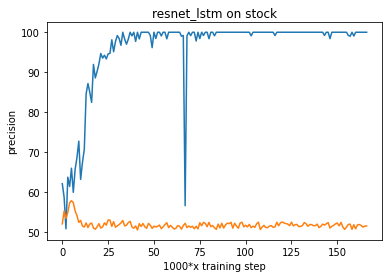

In [17]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [106]:
train_precision

[tensor(nan, device='cuda:1'),
 tensor(54.5455, device='cuda:1'),
 tensor(51.3274, device='cuda:1'),
 tensor(51.6949, device='cuda:1'),
 tensor(48., device='cuda:1'),
 tensor(63.5417, device='cuda:1'),
 tensor(52.5000, device='cuda:1'),
 tensor(59.0164, device='cuda:1'),
 tensor(54.0541, device='cuda:1'),
 tensor(53.4091, device='cuda:1'),
 tensor(59.5745, device='cuda:1'),
 tensor(58.3333, device='cuda:1'),
 tensor(48.8636, device='cuda:1'),
 tensor(59.7015, device='cuda:1'),
 tensor(65.9341, device='cuda:1'),
 tensor(53.0120, device='cuda:1'),
 tensor(64.8649, device='cuda:1'),
 tensor(52.5773, device='cuda:1'),
 tensor(57.6271, device='cuda:1'),
 tensor(51.6129, device='cuda:1'),
 tensor(58.8235, device='cuda:1'),
 tensor(55.8824, device='cuda:1'),
 tensor(55.2083, device='cuda:1'),
 tensor(61.3208, device='cuda:1'),
 tensor(58.3333, device='cuda:1'),
 tensor(64.1221, device='cuda:1'),
 tensor(63.4921, device='cuda:1'),
 tensor(55.1020, device='cuda:1'),
 tensor(63.5135, device='cud

In [18]:
#resnet_lstm trial 1 总结:
#比较快就达到了过拟合点，下一步每100 training step就绘一次图，并减小epoch数

In [19]:
#resnet_lstm trial 2
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 120
learning_rate = 0.001

device = torch.device("cuda:1")

In [24]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [3,4,3], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(ne

In [25]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [26]:
total_step=0
train_precision=[]
valid_precision=[]

In [27]:
#训练
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%100==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [1/120],step[100] Loss:0.6893
precision of the model on thetrainingdata: 55.94405746459961%
precision of the model on thevalidationdata: 52.624114990234375%
Epoch [2/120],step[200] Loss:0.6985
precision of the model on thetrainingdata: 58.53658676147461%
precision of the model on thevalidationdata: 54.826255798339844%
Epoch [2/120],step[300] Loss:0.6936
precision of the model on thetrainingdata: 49.03845977783203%
precision of the model on thevalidationdata: 55.77227020263672%
Epoch [3/120],step[400] Loss:0.6838
precision of the model on thetrainingdata: 65.71428680419922%
precision of the model on thevalidationdata: 54.24836730957031%
Epoch [3/120],step[500] Loss:0.6896
precision of the model on thetrainingdata: 57.5%
precision of the model on thevalidationdata: 53.85572052001953%
Epoch [4/120],step[600] Loss:0.6769
precision of the model on thetrainingdata: 59.64912414550781%
precision of the model on thevalidationdata: 51.40280532836914%
Epoch [5/120],step[700] Loss:0.6861
pre

Epoch [32/120],step[5200] Loss:0.6117
precision of the model on thetrainingdata: 56.19047546386719%
precision of the model on thevalidationdata: 56.84803009033203%
Epoch [32/120],step[5300] Loss:0.6062
precision of the model on thetrainingdata: 58.208953857421875%
precision of the model on thevalidationdata: 53.105140686035156%
Epoch [33/120],step[5400] Loss:0.5950
precision of the model on thetrainingdata: 55.55555725097656%
precision of the model on thevalidationdata: 54.34822463989258%
Epoch [33/120],step[5500] Loss:0.6213
precision of the model on thetrainingdata: 70.2127685546875%
precision of the model on thevalidationdata: 54.011810302734375%
Epoch [34/120],step[5600] Loss:0.6045
precision of the model on thetrainingdata: 51.773048400878906%
precision of the model on thevalidationdata: 52.3397216796875%
Epoch [35/120],step[5700] Loss:0.6049
precision of the model on thetrainingdata: 69.91150665283203%
precision of the model on thevalidationdata: 56.91801834106445%
Epoch [35/120]

precision of the model on thevalidationdata: 52.43330383300781%
Epoch [62/120],step[10300] Loss:0.5659
precision of the model on thetrainingdata: 69.44444274902344%
precision of the model on thevalidationdata: 52.56885528564453%
Epoch [63/120],step[10400] Loss:0.6319
precision of the model on thetrainingdata: 71.17117309570312%
precision of the model on thevalidationdata: 54.926368713378906%
Epoch [63/120],step[10500] Loss:0.5646
precision of the model on thetrainingdata: 70.79646301269531%
precision of the model on thevalidationdata: 51.968299865722656%
Epoch [64/120],step[10600] Loss:0.5526
precision of the model on thetrainingdata: 74.03845977783203%
precision of the model on thevalidationdata: 53.63059616088867%
Epoch [65/120],step[10700] Loss:0.5808
precision of the model on thetrainingdata: 68.54838562011719%
precision of the model on thevalidationdata: 50.99150085449219%
Epoch [65/120],step[10800] Loss:0.5510
precision of the model on thetrainingdata: 66.39344024658203%
precisio

precision of the model on thevalidationdata: 52.202857971191406%
Epoch [92/120],step[15300] Loss:0.4246
precision of the model on thetrainingdata: 86.5079345703125%
precision of the model on thevalidationdata: 52.83177185058594%
Epoch [93/120],step[15400] Loss:0.4617
precision of the model on thetrainingdata: 74.34210205078125%
precision of the model on thevalidationdata: 50.96733093261719%
Epoch [93/120],step[15500] Loss:0.4544
precision of the model on thetrainingdata: 76.85950469970703%
precision of the model on thevalidationdata: 52.914737701416016%
Epoch [94/120],step[15600] Loss:0.4003
precision of the model on thetrainingdata: 89.28571319580078%
precision of the model on thevalidationdata: 51.696006774902344%
Epoch [95/120],step[15700] Loss:0.4260
precision of the model on thetrainingdata: 76.98412322998047%
precision of the model on thevalidationdata: 53.41194152832031%
Epoch [95/120],step[15800] Loss:0.4162
precision of the model on thetrainingdata: 77.67857360839844%
precisio

Text(0, 0.5, 'precision')

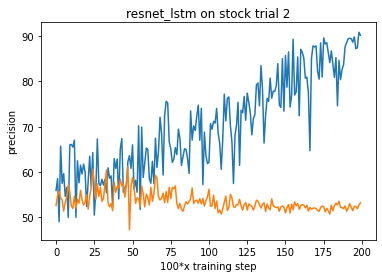

In [29]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock trial 2")
plt.xlabel("100*x training step")
plt.ylabel("precision")

In [31]:
#resnet_lstm trial 2 总结:
#效果在一定区间内达到甚至超过了简单LSTM，但过拟合也很快，下一步调整参数继续试验, 尝试不同取消maxpooling的resnet-lstm。

In [ ]:
#resnet_lstm trial 3
for i in range(3,7):
    # Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    feature_channel=42
    hidden_size = 256  # 隐藏层的size
    num_layers =  3 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 100
    learning_rate = 0.001

    device = torch.device("cuda:1")
    
    resnet_lstm=ResNet1D_LSTM(BasicBlock, [3,4,3], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
    resnet_lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)
    
    total_step=0
    train_precision=[]
    valid_precision=[]
    
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=resnet_lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%100==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
            
    #plot
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("resnet_lstm trial 2, hidden layer:"+str(i))
    plt.xlabel("100*x training step")
    plt.ylabel("precision")
    plt.show()

In [44]:
#resnet_lstm trial 3（no maxpooling）总结：效果并不如原版resnet-lstm
#故放弃这个想法以后的实验还是基于原版resnet-lstm
#下一步试验：用原版resnet-lstm测试不同hidden layer层数的效果

Epoch [1/100],step[100] Loss:0.6891
precision of the model on thetrainingdata: 59.4202880859375%
precision of the model on thevalidationdata: 57.270694732666016%
Epoch [2/100],step[200] Loss:0.6823
precision of the model on thetrainingdata: 50.943397521972656%
precision of the model on thevalidationdata: 55.912296295166016%
Epoch [2/100],step[300] Loss:0.6817
precision of the model on thetrainingdata: 54.54545593261719%
precision of the model on thevalidationdata: 60.041839599609375%
Epoch [3/100],step[400] Loss:0.6875
precision of the model on thetrainingdata: 47.5%
precision of the model on thevalidationdata: 54.08450698852539%
Epoch [3/100],step[500] Loss:0.6816
precision of the model on thetrainingdata: 59.67741775512695%
precision of the model on thevalidationdata: 53.716041564941406%
Epoch [4/100],step[600] Loss:0.6792
precision of the model on thetrainingdata: 59.09090805053711%
precision of the model on thevalidationdata: 57.55287170410156%
Epoch [5/100],step[700] Loss:0.6781
p

precision of the model on thevalidationdata: 55.152889251708984%
Epoch [32/100],step[5200] Loss:0.6251
precision of the model on thetrainingdata: 61.2068977355957%
precision of the model on thevalidationdata: 59.147342681884766%
Epoch [32/100],step[5300] Loss:0.5981
precision of the model on thetrainingdata: 67.70833587646484%
precision of the model on thevalidationdata: 53.10368347167969%
Epoch [33/100],step[5400] Loss:0.5993
precision of the model on thetrainingdata: 71.81818389892578%
precision of the model on thevalidationdata: 54.50777053833008%
Epoch [33/100],step[5500] Loss:0.6219
precision of the model on thetrainingdata: 62.31884002685547%
precision of the model on thevalidationdata: 54.01920700073242%
Epoch [34/100],step[5600] Loss:0.6256
precision of the model on thetrainingdata: 69.84127044677734%
precision of the model on thevalidationdata: 56.40583038330078%
Epoch [35/100],step[5700] Loss:0.6103
precision of the model on thetrainingdata: 58.58585739135742%
precision of th

precision of the model on thevalidationdata: 55.14623260498047%
Epoch [62/100],step[10300] Loss:0.5713
precision of the model on thetrainingdata: 63.44827651977539%
precision of the model on thevalidationdata: 54.161346435546875%
Epoch [63/100],step[10400] Loss:0.5663
precision of the model on thetrainingdata: 68.03278350830078%
precision of the model on thevalidationdata: 53.7098274230957%
Epoch [63/100],step[10500] Loss:0.5648
precision of the model on thetrainingdata: 67.17557525634766%
precision of the model on thevalidationdata: 52.379783630371094%
Epoch [64/100],step[10600] Loss:0.6043
precision of the model on thetrainingdata: 60.15625%
precision of the model on thevalidationdata: 54.92794418334961%
Epoch [65/100],step[10700] Loss:0.5827
precision of the model on thetrainingdata: 73.17073059082031%
precision of the model on thevalidationdata: 51.749813079833984%
Epoch [65/100],step[10800] Loss:0.5426
precision of the model on thetrainingdata: 68.33333587646484%
precision of the 

precision of the model on thevalidationdata: 51.85837936401367%
Epoch [92/100],step[15300] Loss:0.3416
precision of the model on thetrainingdata: 85.9504165649414%
precision of the model on thevalidationdata: 52.30024337768555%
Epoch [93/100],step[15400] Loss:0.3347
precision of the model on thetrainingdata: 88.7218017578125%
precision of the model on thevalidationdata: 53.028839111328125%
Epoch [93/100],step[15500] Loss:0.4780
precision of the model on thetrainingdata: 79.52755737304688%
precision of the model on thevalidationdata: 51.48652267456055%
Epoch [94/100],step[15600] Loss:0.3809
precision of the model on thetrainingdata: 80.32786560058594%
precision of the model on thevalidationdata: 52.37623596191406%
Epoch [95/100],step[15700] Loss:0.3716
precision of the model on thetrainingdata: 74.79674530029297%
precision of the model on thevalidationdata: 53.45232009887695%
Epoch [95/100],step[15800] Loss:0.4188
precision of the model on thetrainingdata: 85.18518829345703%
precision o

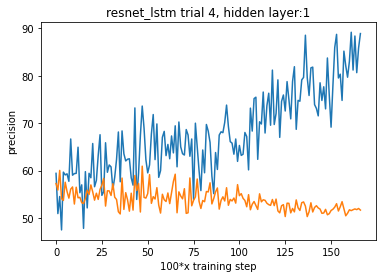

Epoch [1/100],step[100] Loss:0.6765
precision of the model on thetrainingdata: 73.68421173095703%
precision of the model on thevalidationdata: 49.18699264526367%
Epoch [2/100],step[200] Loss:0.6863
precision of the model on thetrainingdata: 65.71428680419922%
precision of the model on thevalidationdata: 52.727272033691406%
Epoch [2/100],step[300] Loss:0.6763
precision of the model on thetrainingdata: 59.09090805053711%
precision of the model on thevalidationdata: 53.795379638671875%
Epoch [3/100],step[400] Loss:0.6751
precision of the model on thetrainingdata: 58.49056625366211%
precision of the model on thevalidationdata: 53.03643798828125%
Epoch [3/100],step[500] Loss:0.6760
precision of the model on thetrainingdata: 61.25%
precision of the model on thevalidationdata: 55.57163619995117%
Epoch [4/100],step[600] Loss:0.6779
precision of the model on thetrainingdata: 65.27777862548828%
precision of the model on thevalidationdata: 55.48854064941406%
Epoch [5/100],step[700] Loss:0.6928
pr

precision of the model on thevalidationdata: 57.9967155456543%
Epoch [32/100],step[5200] Loss:0.6025
precision of the model on thetrainingdata: 57.62711715698242%
precision of the model on thevalidationdata: 57.24551010131836%
Epoch [32/100],step[5300] Loss:0.6155
precision of the model on thetrainingdata: 58.46154022216797%
precision of the model on thevalidationdata: 53.31692123413086%
Epoch [33/100],step[5400] Loss:0.6576
precision of the model on thetrainingdata: 58.653846740722656%
precision of the model on thevalidationdata: 55.32966995239258%
Epoch [33/100],step[5500] Loss:0.5908
precision of the model on thetrainingdata: 67.85713958740234%
precision of the model on thevalidationdata: 57.82621765136719%
Epoch [34/100],step[5600] Loss:0.6460
precision of the model on thetrainingdata: 64.0%
precision of the model on thevalidationdata: 58.03154373168945%
Epoch [35/100],step[5700] Loss:0.6187
precision of the model on thetrainingdata: 63.6363639831543%
precision of the model on thev

Epoch [62/100],step[10200] Loss:0.5518
precision of the model on thetrainingdata: 70.16129302978516%
precision of the model on thevalidationdata: 52.15028381347656%
Epoch [62/100],step[10300] Loss:0.6156
precision of the model on thetrainingdata: 63.5036506652832%
precision of the model on thevalidationdata: 53.738319396972656%
Epoch [63/100],step[10400] Loss:0.5384
precision of the model on thetrainingdata: 70.73170471191406%
precision of the model on thevalidationdata: 52.13454055786133%
Epoch [63/100],step[10500] Loss:0.6635
precision of the model on thetrainingdata: 53.846153259277344%
precision of the model on thevalidationdata: 53.229854583740234%
Epoch [64/100],step[10600] Loss:0.6372
precision of the model on thetrainingdata: 61.53845977783203%
precision of the model on thevalidationdata: 54.71464157104492%
Epoch [65/100],step[10700] Loss:0.5529
precision of the model on thetrainingdata: 64.75409698486328%
precision of the model on thevalidationdata: 57.19370651245117%
Epoch [6

Epoch [92/100],step[15200] Loss:0.4664
precision of the model on thetrainingdata: 76.22950744628906%
precision of the model on thevalidationdata: 51.904579162597656%
Epoch [92/100],step[15300] Loss:0.4365
precision of the model on thetrainingdata: 74.62686920166016%
precision of the model on thevalidationdata: 51.991615295410156%
Epoch [93/100],step[15400] Loss:0.4304
precision of the model on thetrainingdata: 77.96610260009766%
precision of the model on thevalidationdata: 51.87488555908203%
Epoch [93/100],step[15500] Loss:0.5192
precision of the model on thetrainingdata: 72.80000305175781%
precision of the model on thevalidationdata: 51.71459197998047%
Epoch [94/100],step[15600] Loss:0.4935
precision of the model on thetrainingdata: 74.78260803222656%
precision of the model on thevalidationdata: 52.27872085571289%
Epoch [95/100],step[15700] Loss:0.4436
precision of the model on thetrainingdata: 83.59375%
precision of the model on thevalidationdata: 50.6673698425293%
Epoch [95/100],ste

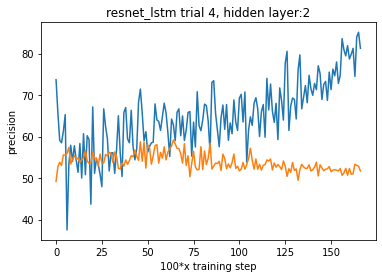

Epoch [1/100],step[100] Loss:0.6977
precision of the model on thetrainingdata: 45.20547866821289%
precision of the model on thevalidationdata: 58.89724349975586%
Epoch [2/100],step[200] Loss:0.6764
precision of the model on thetrainingdata: 51.5625%
precision of the model on thevalidationdata: 57.59162139892578%
Epoch [2/100],step[300] Loss:0.6812
precision of the model on thetrainingdata: 51.5625%
precision of the model on thevalidationdata: 58.35866165161133%
Epoch [3/100],step[400] Loss:0.6739
precision of the model on thetrainingdata: 69.3548355102539%
precision of the model on thevalidationdata: 54.94186019897461%
Epoch [3/100],step[500] Loss:0.6791
precision of the model on thetrainingdata: 62.121212005615234%
precision of the model on thevalidationdata: 58.1267204284668%
Epoch [4/100],step[600] Loss:0.6936
precision of the model on thetrainingdata: 45.0704231262207%
precision of the model on thevalidationdata: 56.76328659057617%
Epoch [5/100],step[700] Loss:0.6725
precision of t

precision of the model on thevalidationdata: 56.81331253051758%
Epoch [32/100],step[5200] Loss:0.5967
precision of the model on thetrainingdata: 63.934425354003906%
precision of the model on thevalidationdata: 52.10579299926758%
Epoch [32/100],step[5300] Loss:0.6291
precision of the model on thetrainingdata: 57.14285659790039%
precision of the model on thevalidationdata: 54.599849700927734%
Epoch [33/100],step[5400] Loss:0.6211
precision of the model on thetrainingdata: 68.96551513671875%
precision of the model on thevalidationdata: 56.03212356567383%
Epoch [33/100],step[5500] Loss:0.6076
precision of the model on thetrainingdata: 65.0%
precision of the model on thevalidationdata: 57.15361404418945%
Epoch [34/100],step[5600] Loss:0.6064
precision of the model on thetrainingdata: 64.51612854003906%
precision of the model on thevalidationdata: 57.07164001464844%
Epoch [35/100],step[5700] Loss:0.6521
precision of the model on thetrainingdata: 59.30232620239258%
precision of the model on t

Epoch [62/100],step[10200] Loss:0.5441
precision of the model on thetrainingdata: 72.4137954711914%
precision of the model on thevalidationdata: 53.76032638549805%
Epoch [62/100],step[10300] Loss:0.5334
precision of the model on thetrainingdata: 70.3125%
precision of the model on thevalidationdata: 52.857704162597656%
Epoch [63/100],step[10400] Loss:0.6651
precision of the model on thetrainingdata: 58.55855941772461%
precision of the model on thevalidationdata: 52.958221435546875%
Epoch [63/100],step[10500] Loss:0.6748
precision of the model on thetrainingdata: 58.57143020629883%
precision of the model on thevalidationdata: 60.62335205078125%
Epoch [64/100],step[10600] Loss:0.6268
precision of the model on thetrainingdata: 65.21739196777344%
precision of the model on thevalidationdata: 59.588130950927734%
Epoch [65/100],step[10700] Loss:0.5984
precision of the model on thetrainingdata: 68.75%
precision of the model on thevalidationdata: 56.97451400756836%
Epoch [65/100],step[10800] Los

Epoch [92/100],step[15200] Loss:0.4621
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 52.185428619384766%
Epoch [92/100],step[15300] Loss:0.4555
precision of the model on thetrainingdata: 70.73170471191406%
precision of the model on thevalidationdata: 51.12031936645508%
Epoch [93/100],step[15400] Loss:0.5176
precision of the model on thetrainingdata: 76.55172729492188%
precision of the model on thevalidationdata: 52.16087341308594%
Epoch [93/100],step[15500] Loss:0.3715
precision of the model on thetrainingdata: 85.71428680419922%
precision of the model on thevalidationdata: 51.98959732055664%
Epoch [94/100],step[15600] Loss:0.4175
precision of the model on thetrainingdata: 83.87096405029297%
precision of the model on thevalidationdata: 50.889007568359375%
Epoch [95/100],step[15700] Loss:0.3688
precision of the model on thetrainingdata: 84.96240234375%
precision of the model on thevalidationdata: 51.43429946899414%
Epoch [95/100],step[1580

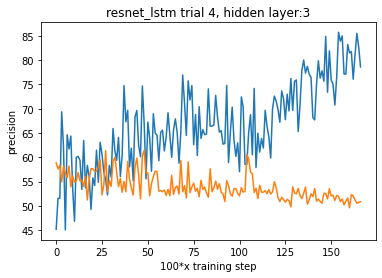

Epoch [1/100],step[100] Loss:0.6909
precision of the model on thetrainingdata: 59.01639175415039%
precision of the model on thevalidationdata: 52.73011016845703%
Epoch [2/100],step[200] Loss:0.6903
precision of the model on thetrainingdata: 60.0%
precision of the model on thevalidationdata: 55.18394470214844%
Epoch [2/100],step[300] Loss:0.6862
precision of the model on thetrainingdata: 55.29411697387695%
precision of the model on thevalidationdata: 57.02764892578125%
Epoch [3/100],step[400] Loss:0.6801
precision of the model on thetrainingdata: 60.227272033691406%
precision of the model on thevalidationdata: 53.0379753112793%
Epoch [3/100],step[500] Loss:0.6845
precision of the model on thetrainingdata: 47.272727966308594%
precision of the model on thevalidationdata: 54.063018798828125%
Epoch [4/100],step[600] Loss:0.6641
precision of the model on thetrainingdata: 59.52381134033203%
precision of the model on thevalidationdata: 54.78662109375%
Epoch [5/100],step[700] Loss:0.6869
precis

precision of the model on thevalidationdata: 53.76953125%
Epoch [32/100],step[5200] Loss:0.6437
precision of the model on thetrainingdata: 51.19047546386719%
precision of the model on thevalidationdata: 52.78810501098633%
Epoch [32/100],step[5300] Loss:0.6596
precision of the model on thetrainingdata: 59.0476188659668%
precision of the model on thevalidationdata: 54.733036041259766%
Epoch [33/100],step[5400] Loss:0.6194
precision of the model on thetrainingdata: 67.85713958740234%
precision of the model on thevalidationdata: 58.687442779541016%
Epoch [33/100],step[5500] Loss:0.5896
precision of the model on thetrainingdata: 70.27027130126953%
precision of the model on thevalidationdata: 54.81324768066406%
Epoch [34/100],step[5600] Loss:0.6122
precision of the model on thetrainingdata: 57.894737243652344%
precision of the model on thevalidationdata: 52.8801155090332%
Epoch [35/100],step[5700] Loss:0.6173
precision of the model on thetrainingdata: 56.488548278808594%
precision of the mod

Epoch [62/100],step[10200] Loss:0.5246
precision of the model on thetrainingdata: 69.23076629638672%
precision of the model on thevalidationdata: 53.54816436767578%
Epoch [62/100],step[10300] Loss:0.6015
precision of the model on thetrainingdata: 70.64220428466797%
precision of the model on thevalidationdata: 54.35497283935547%
Epoch [63/100],step[10400] Loss:0.5269
precision of the model on thetrainingdata: 73.58490753173828%
precision of the model on thevalidationdata: 52.93425369262695%
Epoch [63/100],step[10500] Loss:0.5523
precision of the model on thetrainingdata: 72.35772705078125%
precision of the model on thevalidationdata: 54.48468017578125%
Epoch [64/100],step[10600] Loss:0.5584
precision of the model on thetrainingdata: 71.07437896728516%
precision of the model on thevalidationdata: 51.516265869140625%
Epoch [65/100],step[10700] Loss:0.6028
precision of the model on thetrainingdata: 65.0943374633789%
precision of the model on thevalidationdata: 55.35748291015625%
Epoch [65/

Epoch [92/100],step[15200] Loss:0.4277
precision of the model on thetrainingdata: 75.37313079833984%
precision of the model on thevalidationdata: 52.224273681640625%
Epoch [92/100],step[15300] Loss:0.4287
precision of the model on thetrainingdata: 76.72413635253906%
precision of the model on thevalidationdata: 51.102752685546875%
Epoch [93/100],step[15400] Loss:0.3961
precision of the model on thetrainingdata: 81.06060791015625%
precision of the model on thevalidationdata: 51.234657287597656%
Epoch [93/100],step[15500] Loss:0.4472
precision of the model on thetrainingdata: 78.07017517089844%
precision of the model on thevalidationdata: 52.404170989990234%
Epoch [94/100],step[15600] Loss:0.4905
precision of the model on thetrainingdata: 73.68421173095703%
precision of the model on thevalidationdata: 52.17546844482422%
Epoch [95/100],step[15700] Loss:0.3868
precision of the model on thetrainingdata: 78.04878234863281%
precision of the model on thevalidationdata: 52.54550552368164%
Epoch 

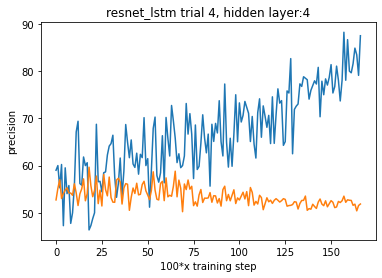

Epoch [1/100],step[100] Loss:0.6825
precision of the model on thetrainingdata: 54.4715461730957%
precision of the model on thevalidationdata: 51.077388763427734%
Epoch [2/100],step[200] Loss:0.6998
precision of the model on thetrainingdata: 45.28302001953125%
precision of the model on thevalidationdata: 52.61250305175781%
Epoch [2/100],step[300] Loss:0.6832
precision of the model on thetrainingdata: 56.25%
precision of the model on thevalidationdata: 68.60465240478516%
Epoch [3/100],step[400] Loss:0.6908
precision of the model on thetrainingdata: 61.904762268066406%
precision of the model on thevalidationdata: 54.871795654296875%
Epoch [3/100],step[500] Loss:0.6826
precision of the model on thetrainingdata: 60.227272033691406%
precision of the model on thevalidationdata: 55.366268157958984%
Epoch [4/100],step[600] Loss:0.6972
precision of the model on thetrainingdata: 56.09756088256836%
precision of the model on thevalidationdata: 54.9237174987793%
Epoch [5/100],step[700] Loss:0.6796
p

precision of the model on thevalidationdata: 56.19613265991211%
Epoch [32/100],step[5200] Loss:0.6413
precision of the model on thetrainingdata: 56.034481048583984%
precision of the model on thevalidationdata: 53.25537109375%
Epoch [32/100],step[5300] Loss:0.6551
precision of the model on thetrainingdata: 58.46154022216797%
precision of the model on thevalidationdata: 55.24129104614258%
Epoch [33/100],step[5400] Loss:0.6361
precision of the model on thetrainingdata: 65.68627166748047%
precision of the model on thevalidationdata: 53.29341506958008%
Epoch [33/100],step[5500] Loss:0.6416
precision of the model on thetrainingdata: 53.9822998046875%
precision of the model on thevalidationdata: 53.84928894042969%
Epoch [34/100],step[5600] Loss:0.5964
precision of the model on thetrainingdata: 62.26415252685547%
precision of the model on thevalidationdata: 52.87034606933594%
Epoch [35/100],step[5700] Loss:0.6105
precision of the model on thetrainingdata: 60.21505355834961%
precision of the mo

Epoch [62/100],step[10200] Loss:0.5618
precision of the model on thetrainingdata: 70.54263305664062%
precision of the model on thevalidationdata: 51.576576232910156%
Epoch [62/100],step[10300] Loss:0.5388
precision of the model on thetrainingdata: 70.1754379272461%
precision of the model on thevalidationdata: 51.72935104370117%
Epoch [63/100],step[10400] Loss:0.5619
precision of the model on thetrainingdata: 73.04964447021484%
precision of the model on thevalidationdata: 51.957489013671875%
Epoch [63/100],step[10500] Loss:0.5631
precision of the model on thetrainingdata: 73.91304016113281%
precision of the model on thevalidationdata: 53.283267974853516%
Epoch [64/100],step[10600] Loss:0.5937
precision of the model on thetrainingdata: 66.18704986572266%
precision of the model on thevalidationdata: 51.39146423339844%
Epoch [65/100],step[10700] Loss:0.5553
precision of the model on thetrainingdata: 63.6363639831543%
precision of the model on thevalidationdata: 51.95759582519531%
Epoch [65

Epoch [92/100],step[15200] Loss:0.5771
precision of the model on thetrainingdata: 65.28925323486328%
precision of the model on thevalidationdata: 53.00291442871094%
Epoch [92/100],step[15300] Loss:0.5393
precision of the model on thetrainingdata: 70.0%
precision of the model on thevalidationdata: 51.894737243652344%
Epoch [93/100],step[15400] Loss:0.4963
precision of the model on thetrainingdata: 76.29629516601562%
precision of the model on thevalidationdata: 52.392704010009766%
Epoch [93/100],step[15500] Loss:0.5140
precision of the model on thetrainingdata: 75.83333587646484%
precision of the model on thevalidationdata: 51.57232666015625%
Epoch [94/100],step[15600] Loss:0.5194
precision of the model on thetrainingdata: 70.28985595703125%
precision of the model on thevalidationdata: 50.447608947753906%
Epoch [95/100],step[15700] Loss:0.5139
precision of the model on thetrainingdata: 75.65217590332031%
precision of the model on thevalidationdata: 49.5679931640625%
Epoch [95/100],step[1

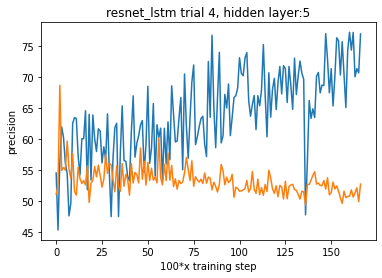

Epoch [1/100],step[100] Loss:0.6812
precision of the model on thetrainingdata: 47.25274658203125%
precision of the model on thevalidationdata: 51.38831329345703%
Epoch [2/100],step[200] Loss:0.6881
precision of the model on thetrainingdata: 51.11111068725586%
precision of the model on thevalidationdata: 55.238094329833984%
Epoch [2/100],step[300] Loss:0.6868
precision of the model on thetrainingdata: 52.52525329589844%
precision of the model on thevalidationdata: 51.740055084228516%
Epoch [3/100],step[400] Loss:0.6918
precision of the model on thetrainingdata: 58.13953399658203%
precision of the model on thevalidationdata: 54.226802825927734%
Epoch [3/100],step[500] Loss:0.6790
precision of the model on thetrainingdata: 60.975608825683594%
precision of the model on thevalidationdata: 54.66034698486328%
Epoch [4/100],step[600] Loss:0.6764
precision of the model on thetrainingdata: 58.227848052978516%
precision of the model on thevalidationdata: 53.99568176269531%
Epoch [5/100],step[700]

precision of the model on thevalidationdata: 57.562076568603516%
Epoch [32/100],step[5200] Loss:0.6060
precision of the model on thetrainingdata: 79.46428680419922%
precision of the model on thevalidationdata: 50.125606536865234%
Epoch [32/100],step[5300] Loss:0.6012
precision of the model on thetrainingdata: 75.71428680419922%
precision of the model on thevalidationdata: 54.93101501464844%
Epoch [33/100],step[5400] Loss:0.6392
precision of the model on thetrainingdata: 64.21052551269531%
precision of the model on thevalidationdata: 53.93367385864258%
Epoch [33/100],step[5500] Loss:0.6038
precision of the model on thetrainingdata: 65.45454406738281%
precision of the model on thevalidationdata: 51.76744842529297%
Epoch [34/100],step[5600] Loss:0.6419
precision of the model on thetrainingdata: 69.69696807861328%
precision of the model on thevalidationdata: 54.45783233642578%
Epoch [35/100],step[5700] Loss:0.6107
precision of the model on thetrainingdata: 65.06024169921875%
precision of t

Epoch [62/100],step[10200] Loss:0.5979
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 50.45688247680664%
Epoch [62/100],step[10300] Loss:0.5443
precision of the model on thetrainingdata: 69.36936950683594%
precision of the model on thevalidationdata: 53.42044448852539%
Epoch [63/100],step[10400] Loss:0.5608
precision of the model on thetrainingdata: 72.4137954711914%
precision of the model on thevalidationdata: 53.9871826171875%
Epoch [63/100],step[10500] Loss:0.5577
precision of the model on thetrainingdata: 69.7368392944336%
precision of the model on thevalidationdata: 52.18541717529297%
Epoch [64/100],step[10600] Loss:0.5767
precision of the model on thetrainingdata: 67.22689056396484%
precision of the model on thevalidationdata: 53.259361267089844%
Epoch [65/100],step[10700] Loss:0.6017
precision of the model on thetrainingdata: 60.15037536621094%
precision of the model on thevalidationdata: 52.41654968261719%
Epoch [65/10

Epoch [92/100],step[15200] Loss:0.4518
precision of the model on thetrainingdata: 69.01408386230469%
precision of the model on thevalidationdata: 51.54902267456055%
Epoch [92/100],step[15300] Loss:0.4472
precision of the model on thetrainingdata: 78.6259536743164%
precision of the model on thevalidationdata: 50.484745025634766%
Epoch [93/100],step[15400] Loss:0.5187
precision of the model on thetrainingdata: 77.77777862548828%
precision of the model on thevalidationdata: 52.48748016357422%
Epoch [93/100],step[15500] Loss:0.5344
precision of the model on thetrainingdata: 71.96969604492188%
precision of the model on thevalidationdata: 52.34772872924805%
Epoch [94/100],step[15600] Loss:0.4739
precision of the model on thetrainingdata: 75.5905532836914%
precision of the model on thevalidationdata: 50.87393569946289%
Epoch [95/100],step[15700] Loss:0.4275
precision of the model on thetrainingdata: 75.89286041259766%
precision of the model on thevalidationdata: 51.46272277832031%
Epoch [95/1

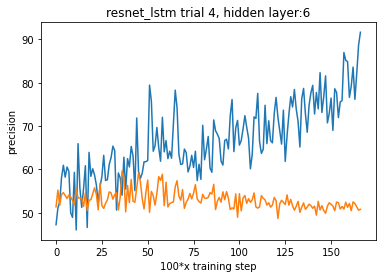

In [47]:
#resnet_lstm trial 4
for i in range(1,7):
    # Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    feature_channel=42
    hidden_size = 256  # 隐藏层的size
    num_layers =  3 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 100
    learning_rate = 0.001

    device = torch.device("cuda:1")
    
    resnet_lstm=ResNet1D_LSTM(BasicBlock, [3,4,3], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
    resnet_lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)
    
    total_step=0
    train_precision=[]
    valid_precision=[]
    
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=resnet_lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%100==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
            
    #plot
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("resnet_lstm trial 4, hidden layer:"+str(i))
    plt.xlabel("100*x training step")
    plt.ylabel("precision")
    plt.show()

In [48]:
#resnet_lstm trial 4 总结：效果和之前没有太大差别
#故放弃这个想法以后的实验还是基于原版resnet-lstm
#下一步试验：减小resnet部分的深度，减小模型复杂度

In [49]:
#resnet_lstm trial 5
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 120
learning_rate = 0.001

device = torch.device("cuda:1")

In [50]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(128, 128, kernel

In [51]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [52]:
total_step=0
train_precision=[]
valid_precision=[]

In [53]:
#训练
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%100==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [1/120],step[100] Loss:0.6747
precision of the model on thetrainingdata: 59.52381134033203%
precision of the model on thevalidationdata: 59.01639175415039%
Epoch [2/120],step[200] Loss:0.6848
precision of the model on thetrainingdata: 56.578948974609375%
precision of the model on thevalidationdata: 56.68662643432617%
Epoch [2/120],step[300] Loss:0.6803
precision of the model on thetrainingdata: 61.53845977783203%
precision of the model on thevalidationdata: 57.22713851928711%
Epoch [3/120],step[400] Loss:0.6932
precision of the model on thetrainingdata: 54.117645263671875%
precision of the model on thevalidationdata: 54.2302360534668%
Epoch [3/120],step[500] Loss:0.6717
precision of the model on thetrainingdata: 55.681819915771484%
precision of the model on thevalidationdata: 55.491329193115234%
Epoch [4/120],step[600] Loss:0.6787
precision of the model on thetrainingdata: 63.492061614990234%
precision of the model on thevalidationdata: 51.75718688964844%
Epoch [5/120],step[700] 

precision of the model on thevalidationdata: 57.36961364746094%
Epoch [32/120],step[5200] Loss:0.5957
precision of the model on thetrainingdata: 68.0851058959961%
precision of the model on thevalidationdata: 58.93939208984375%
Epoch [32/120],step[5300] Loss:0.6006
precision of the model on thetrainingdata: 61.797752380371094%
precision of the model on thevalidationdata: 55.81111526489258%
Epoch [33/120],step[5400] Loss:0.6095
precision of the model on thetrainingdata: 64.8648681640625%
precision of the model on thevalidationdata: 55.976417541503906%
Epoch [33/120],step[5500] Loss:0.6097
precision of the model on thetrainingdata: 67.67676544189453%
precision of the model on thevalidationdata: 62.10369110107422%
Epoch [34/120],step[5600] Loss:0.6000
precision of the model on thetrainingdata: 77.2151870727539%
precision of the model on thevalidationdata: 57.73118591308594%
Epoch [35/120],step[5700] Loss:0.5986
precision of the model on thetrainingdata: 66.3043441772461%
precision of the m

Epoch [62/120],step[10200] Loss:0.4559
precision of the model on thetrainingdata: 74.79674530029297%
precision of the model on thevalidationdata: 51.20402145385742%
Epoch [62/120],step[10300] Loss:0.5173
precision of the model on thetrainingdata: 78.4000015258789%
precision of the model on thevalidationdata: 53.824825286865234%
Epoch [63/120],step[10400] Loss:0.4390
precision of the model on thetrainingdata: 77.14286041259766%
precision of the model on thevalidationdata: 50.840335845947266%
Epoch [63/120],step[10500] Loss:0.5189
precision of the model on thetrainingdata: 70.09346008300781%
precision of the model on thevalidationdata: 53.68239212036133%
Epoch [64/120],step[10600] Loss:0.4444
precision of the model on thetrainingdata: 72.03389739990234%
precision of the model on thevalidationdata: 52.50914764404297%
Epoch [65/120],step[10700] Loss:0.4303
precision of the model on thetrainingdata: 81.19657897949219%
precision of the model on thevalidationdata: 53.85344696044922%
Epoch [65

Epoch [92/120],step[15200] Loss:0.2144
precision of the model on thetrainingdata: 91.6030502319336%
precision of the model on thevalidationdata: 52.138797760009766%
Epoch [92/120],step[15300] Loss:0.2147
precision of the model on thetrainingdata: 85.71428680419922%
precision of the model on thevalidationdata: 52.03845977783203%
Epoch [93/120],step[15400] Loss:0.1959
precision of the model on thetrainingdata: 92.85713958740234%
precision of the model on thevalidationdata: 52.07170486450195%
Epoch [93/120],step[15500] Loss:0.2646
precision of the model on thetrainingdata: 94.82758331298828%
precision of the model on thevalidationdata: 51.940093994140625%
Epoch [94/120],step[15600] Loss:0.2587
precision of the model on thetrainingdata: 91.73553466796875%
precision of the model on thevalidationdata: 51.4931755065918%
Epoch [95/120],step[15700] Loss:0.2691
precision of the model on thetrainingdata: 92.91338348388672%
precision of the model on thevalidationdata: 51.0007209777832%
Epoch [95/1

Text(0, 0.5, 'precision')

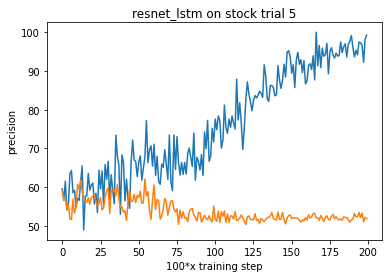

In [54]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock trial 5")
plt.xlabel("100*x training step")
plt.ylabel("precision")

In [56]:
#resnet_lstm trial 5 总结：效果和之前没有太大差别
#下一步试验：将batch_norm删除看效果，其余参数与trial5保持一致

In [57]:
#resnet_lstm trial 6
#搭建第一类ResNet block
class BasicBlock(nn.Module):#基本残差网络的一个模块类
    expansion = 1#每一个residual block中不改变width,height,channel数，即增加的residual部分不需要做卷积处理

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)#stride=1,kernel_size=3,padding=1保证了data的
                                                                                   #size不变 
        #self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:  #BasicBlock内不需要调整residual的height,width,channel
            identity = self.downsample(x)

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


# In[7]:


#组建block成ResNet
class ResNet1D_LSTM(nn.Module):
    def __init__(self, block, blocks_num, num_classes, feature_channel,hidden_size, num_layers,device ):
        super(ResNet1D_LSTM, self).__init__()
        self.in_channel = 64
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv1d(in_channels=feature_channel, out_channels=self.in_channel, kernel_size=2, stride=2,
                               padding=0, bias=False)
        #self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  #channel数变为n/2(非整数时向下取整)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])         #按照已有结论按二次方形式增长ResNet不同阶段的channel
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2表示想把上一个layer传过来的size缩减为1/2
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        #self.avgpool = nn.AdaptiveAvgPool1d((1, 1))  # output size = (1, 1) 
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #预处理
        #x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #残差网络
        x = self.layer2(x)
        x = self.layer3(x)
        
        x=torch.transpose(x,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [58]:
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 120
learning_rate = 0.001

device = torch.device("cuda:1")

In [59]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (relu): ReLU()
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (downsample): Sequential(
        (0): Conv1d(64, 128, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=Fal

In [60]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [61]:
total_step=0
train_precision=[]
valid_precision=[]

In [62]:
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%100==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [1/120],step[100] Loss:0.6972
precision of the model on thetrainingdata: 71.0526351928711%
precision of the model on thevalidationdata: 63.46154022216797%
Epoch [2/120],step[200] Loss:0.6701
precision of the model on thetrainingdata: 56.47058868408203%
precision of the model on thevalidationdata: 51.43104934692383%
Epoch [2/120],step[300] Loss:0.6962
precision of the model on thetrainingdata: 51.37614822387695%
precision of the model on thevalidationdata: 51.22806930541992%
Epoch [3/120],step[400] Loss:0.6907
precision of the model on thetrainingdata: 65.11627960205078%
precision of the model on thevalidationdata: 64.44444274902344%
Epoch [3/120],step[500] Loss:0.6811
precision of the model on thetrainingdata: 61.70212936401367%
precision of the model on thevalidationdata: 53.633216857910156%
Epoch [4/120],step[600] Loss:0.6874
precision of the model on thetrainingdata: 60.56338119506836%
precision of the model on thevalidationdata: 49.93215560913086%
Epoch [5/120],step[700] Loss

precision of the model on thevalidationdata: 52.023624420166016%
Epoch [32/120],step[5200] Loss:0.6362
precision of the model on thetrainingdata: 61.467891693115234%
precision of the model on thevalidationdata: 57.57423400878906%
Epoch [32/120],step[5300] Loss:0.5769
precision of the model on thetrainingdata: 65.43209838867188%
precision of the model on thevalidationdata: 53.0157356262207%
Epoch [33/120],step[5400] Loss:0.5803
precision of the model on thetrainingdata: 71.07437896728516%
precision of the model on thevalidationdata: 49.194149017333984%
Epoch [33/120],step[5500] Loss:0.5827
precision of the model on thetrainingdata: 68.9189224243164%
precision of the model on thevalidationdata: 57.80644989013672%
Epoch [34/120],step[5600] Loss:0.5527
precision of the model on thetrainingdata: 70.45454406738281%
precision of the model on thevalidationdata: 58.59499740600586%
Epoch [35/120],step[5700] Loss:0.5929
precision of the model on thetrainingdata: 67.77777862548828%
precision of th

Epoch [62/120],step[10200] Loss:0.3873
precision of the model on thetrainingdata: 86.53845977783203%
precision of the model on thevalidationdata: 52.403099060058594%
Epoch [62/120],step[10300] Loss:0.4059
precision of the model on thetrainingdata: 82.6446304321289%
precision of the model on thevalidationdata: 52.28538131713867%
Epoch [63/120],step[10400] Loss:0.3335
precision of the model on thetrainingdata: 81.19657897949219%
precision of the model on thevalidationdata: 52.59674072265625%
Epoch [63/120],step[10500] Loss:0.3591
precision of the model on thetrainingdata: 81.61764526367188%
precision of the model on thevalidationdata: 51.59718322753906%
Epoch [64/120],step[10600] Loss:0.3579
precision of the model on thetrainingdata: 87.90322875976562%
precision of the model on thevalidationdata: 52.456138610839844%
Epoch [65/120],step[10700] Loss:0.3493
precision of the model on thetrainingdata: 83.96226501464844%
precision of the model on thevalidationdata: 53.50333023071289%
Epoch [65

precision of the model on thevalidationdata: 52.60416793823242%
Epoch [92/120],step[15300] Loss:0.2085
precision of the model on thetrainingdata: 93.87754821777344%
precision of the model on thevalidationdata: 53.069271087646484%
Epoch [93/120],step[15400] Loss:0.1561
precision of the model on thetrainingdata: 95.19999694824219%
precision of the model on thevalidationdata: 51.94381332397461%
Epoch [93/120],step[15500] Loss:0.2753
precision of the model on thetrainingdata: 93.0434799194336%
precision of the model on thevalidationdata: 53.46895217895508%
Epoch [94/120],step[15600] Loss:0.2060
precision of the model on thetrainingdata: 84.78260803222656%
precision of the model on thevalidationdata: 52.15860366821289%
Epoch [95/120],step[15700] Loss:0.1763
precision of the model on thetrainingdata: 92.30769348144531%
precision of the model on thevalidationdata: 52.532901763916016%
Epoch [95/120],step[15800] Loss:0.2834
precision of the model on thetrainingdata: 93.91304016113281%
precision

Text(0, 0.5, 'precision')

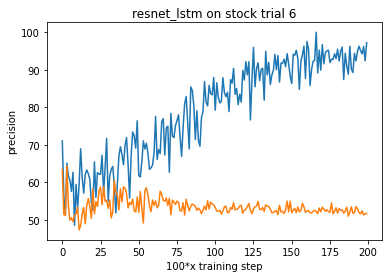

In [63]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock trial 6")
plt.xlabel("100*x training step")
plt.ylabel("precision")

In [64]:
#resnet_lstm trial 6 总结：效果和之前没有太大差别
#下一步试验：保留原来的batch_norm, 改为将第三类resnet block删除

In [73]:
#搭建第一类ResNet block
class BasicBlock(nn.Module):#基本残差网络的一个模块类
    expansion = 1#每一个residual block中不改变width,height,channel数，即增加的residual部分不需要做卷积处理

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)#stride=1,kernel_size=3,padding=1保证了data的
                                                                                   #size不变 
        #self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:  #BasicBlock内不需要调整residual的height,width,channel
            identity = self.downsample(x)

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


# In[7]:


#组建block成ResNet
class ResNet1D_LSTM(nn.Module):
    def __init__(self, block, blocks_num, num_classes, feature_channel,hidden_size, num_layers,device ):
        super(ResNet1D_LSTM, self).__init__()
        self.in_channel = 64
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv1d(in_channels=feature_channel, out_channels=self.in_channel, kernel_size=2, stride=2,
                               padding=0, bias=False)
        #self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  #channel数变为n/2(非整数时向下取整)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])         #按照已有结论按二次方形式增长ResNet不同阶段的channel
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2表示想把上一个layer传过来的size缩减为1/2
        #self.avgpool = nn.AdaptiveAvgPool1d((1, 1))  # output size = (1, 1) 
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #预处理
        #x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #残差网络
        x = self.layer2(x)
        
        x=torch.transpose(x,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [74]:
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 128  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 120
learning_rate = 0.001

device = torch.device("cuda:1")

In [75]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (relu): ReLU()
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (downsample): Sequential(
        (0): Conv1d(64, 128, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=Fal

In [76]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [77]:
total_step=0
train_precision=[]
valid_precision=[]

In [78]:
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%100==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [1/120],step[100] Loss:0.6868
precision of the model on thetrainingdata: 47.05882263183594%
precision of the model on thevalidationdata: 49.58632278442383%
Epoch [2/120],step[200] Loss:0.6747
precision of the model on thetrainingdata: 56.17977523803711%
precision of the model on thevalidationdata: 52.124183654785156%
Epoch [2/120],step[300] Loss:0.6871
precision of the model on thetrainingdata: 70.1754379272461%
precision of the model on thevalidationdata: 49.46043014526367%
Epoch [3/120],step[400] Loss:0.6902
precision of the model on thetrainingdata: 51.960784912109375%
precision of the model on thevalidationdata: 52.448211669921875%
Epoch [3/120],step[500] Loss:0.6849
precision of the model on thetrainingdata: 45.0%
precision of the model on thevalidationdata: 56.86274337768555%
Epoch [4/120],step[600] Loss:0.6521
precision of the model on thetrainingdata: 54.16666793823242%
precision of the model on thevalidationdata: 49.14285659790039%
Epoch [5/120],step[700] Loss:0.6875
pre

precision of the model on thevalidationdata: 53.66726303100586%
Epoch [32/120],step[5200] Loss:0.6401
precision of the model on thetrainingdata: 61.42856979370117%
precision of the model on thevalidationdata: 56.81438064575195%
Epoch [32/120],step[5300] Loss:0.6244
precision of the model on thetrainingdata: 63.33333206176758%
precision of the model on thevalidationdata: 59.34959411621094%
Epoch [33/120],step[5400] Loss:0.6079
precision of the model on thetrainingdata: 75.29412078857422%
precision of the model on thevalidationdata: 51.5625%
Epoch [33/120],step[5500] Loss:0.6435
precision of the model on thetrainingdata: 65.11627960205078%
precision of the model on thevalidationdata: 57.509159088134766%
Epoch [34/120],step[5600] Loss:0.6078
precision of the model on thetrainingdata: 64.34782409667969%
precision of the model on thevalidationdata: 57.340152740478516%
Epoch [35/120],step[5700] Loss:0.6001
precision of the model on thetrainingdata: 73.07691955566406%
precision of the model o

Epoch [62/120],step[10200] Loss:0.4795
precision of the model on thetrainingdata: 77.45098114013672%
precision of the model on thevalidationdata: 54.067230224609375%
Epoch [62/120],step[10300] Loss:0.5146
precision of the model on thetrainingdata: 74.38016510009766%
precision of the model on thevalidationdata: 56.09233856201172%
Epoch [63/120],step[10400] Loss:0.4971
precision of the model on thetrainingdata: 77.5700912475586%
precision of the model on thevalidationdata: 50.243011474609375%
Epoch [63/120],step[10500] Loss:0.4862
precision of the model on thetrainingdata: 74.77477264404297%
precision of the model on thevalidationdata: 52.94294357299805%
Epoch [64/120],step[10600] Loss:0.5199
precision of the model on thetrainingdata: 69.04762268066406%
precision of the model on thevalidationdata: 54.32499694824219%
Epoch [65/120],step[10700] Loss:0.4383
precision of the model on thetrainingdata: 82.85713958740234%
precision of the model on thevalidationdata: 52.63372039794922%
Epoch [65

Epoch [92/120],step[15200] Loss:0.2424
precision of the model on thetrainingdata: 84.34782409667969%
precision of the model on thevalidationdata: 52.05299758911133%
Epoch [92/120],step[15300] Loss:0.2841
precision of the model on thetrainingdata: 88.98304748535156%
precision of the model on thevalidationdata: 52.402069091796875%
Epoch [93/120],step[15400] Loss:0.2662
precision of the model on thetrainingdata: 91.37931060791016%
precision of the model on thevalidationdata: 51.71087646484375%
Epoch [93/120],step[15500] Loss:0.2620
precision of the model on thetrainingdata: 84.96240234375%
precision of the model on thevalidationdata: 50.921871185302734%
Epoch [94/120],step[15600] Loss:0.2472
precision of the model on thetrainingdata: 93.75%
precision of the model on thevalidationdata: 52.30635452270508%
Epoch [95/120],step[15700] Loss:0.2287
precision of the model on thetrainingdata: 92.06349182128906%
precision of the model on thevalidationdata: 53.48654556274414%
Epoch [95/120],step[158

Text(0, 0.5, 'precision')

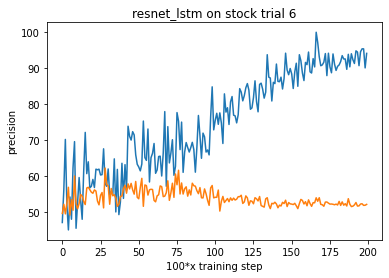

In [80]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock trial 6")
plt.xlabel("100*x training step")
plt.ylabel("precision")

In [81]:
#resnet_lstm trial 7
#尝试用dropout解决过拟合
#搭建第一类ResNet block
class BasicBlock(nn.Module):#基本残差网络的一个模块类
    expansion = 1#每一个residual block中不改变width,height,channel数，即增加的residual部分不需要做卷积处理

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)#stride=1,kernel_size=3,padding=1保证了data的
        self.drop = nn.Dropout(0.7)                                                                           #size不变 
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:  #BasicBlock内不需要调整residual的height,width,channel
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


# In[7]:


#组建block成ResNet
class ResNet1D_LSTM(nn.Module):
    def __init__(self, block, blocks_num, num_classes, feature_channel,hidden_size, num_layers,device ):
        super(ResNet1D_LSTM, self).__init__()
        self.in_channel = 64
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(in_channels=feature_channel, out_channels=self.in_channel, kernel_size=2, stride=2,
                               padding=0, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  #channel数变为n/2(非整数时向下取整)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])         #按照已有结论按二次方形式增长ResNet不同阶段的channel
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2表示想把上一个layer传过来的size缩减为1/2
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        #self.avgpool = nn.AdaptiveAvgPool1d((1, 1))  # output size = (1, 1) 
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #预处理
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #残差网络
        x = self.layer2(x)
        x = self.layer3(x)
        
        x=torch.transpose(x,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [82]:
def predict_precision(model,images,labels,device,predict_type):
    model.eval()
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    model.train()
    return predicted, 100*correct/total

In [85]:
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 120
learning_rate = 0.001

device = torch.device("cuda:1")

In [86]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (drop): Dropout(p=0.7, inplace=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (drop): Dropout(p=0.7, inplace=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=Tru

In [87]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [88]:
total_step=0
train_precision=[]
valid_precision=[]

In [89]:
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%100==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [1/120],step[100] Loss:0.6958
precision of the model on thetrainingdata: 55.084747314453125%
precision of the model on thevalidationdata: 54.019290924072266%
Epoch [2/120],step[200] Loss:0.6928
precision of the model on thetrainingdata: 48.52941131591797%
precision of the model on thevalidationdata: 52.6054573059082%
Epoch [2/120],step[300] Loss:0.6978
precision of the model on thetrainingdata: 50.0%
precision of the model on thevalidationdata: 56.07808303833008%
Epoch [3/120],step[400] Loss:0.6705
precision of the model on thetrainingdata: 65.28925323486328%
precision of the model on thevalidationdata: 53.39457702636719%
Epoch [3/120],step[500] Loss:0.6786
precision of the model on thetrainingdata: 54.9295768737793%
precision of the model on thevalidationdata: 54.25867462158203%
Epoch [4/120],step[600] Loss:0.7045
precision of the model on thetrainingdata: 54.94505310058594%
precision of the model on thevalidationdata: 54.775508880615234%
Epoch [5/120],step[700] Loss:0.6927
prec

precision of the model on thevalidationdata: 54.473758697509766%
Epoch [32/120],step[5200] Loss:0.6023
precision of the model on thetrainingdata: 70.52631378173828%
precision of the model on thevalidationdata: 58.99470901489258%
Epoch [32/120],step[5300] Loss:0.6290
precision of the model on thetrainingdata: 59.82143020629883%
precision of the model on thevalidationdata: 58.157432556152344%
Epoch [33/120],step[5400] Loss:0.6314
precision of the model on thetrainingdata: 63.157894134521484%
precision of the model on thevalidationdata: 55.583919525146484%
Epoch [33/120],step[5500] Loss:0.6170
precision of the model on thetrainingdata: 63.28125%
precision of the model on thevalidationdata: 57.71604919433594%
Epoch [34/120],step[5600] Loss:0.6039
precision of the model on thetrainingdata: 54.9549560546875%
precision of the model on thevalidationdata: 55.83137130737305%
Epoch [35/120],step[5700] Loss:0.6220
precision of the model on thetrainingdata: 60.0%
precision of the model on thevalida

Epoch [62/120],step[10200] Loss:0.5540
precision of the model on thetrainingdata: 75.89286041259766%
precision of the model on thevalidationdata: 58.912208557128906%
Epoch [62/120],step[10300] Loss:0.5765
precision of the model on thetrainingdata: 61.739131927490234%
precision of the model on thevalidationdata: 55.70906066894531%
Epoch [63/120],step[10400] Loss:0.6107
precision of the model on thetrainingdata: 62.601627349853516%
precision of the model on thevalidationdata: 56.62119674682617%
Epoch [63/120],step[10500] Loss:0.5743
precision of the model on thetrainingdata: 71.84465789794922%
precision of the model on thevalidationdata: 55.80967330932617%
Epoch [64/120],step[10600] Loss:0.5964
precision of the model on thetrainingdata: 64.1025619506836%
precision of the model on thevalidationdata: 55.715396881103516%
Epoch [65/120],step[10700] Loss:0.6046
precision of the model on thetrainingdata: 64.39393615722656%
precision of the model on thevalidationdata: 55.783443450927734%
Epoch 

Epoch [92/120],step[15200] Loss:0.5235
precision of the model on thetrainingdata: 77.86885070800781%
precision of the model on thevalidationdata: 52.86717987060547%
Epoch [92/120],step[15300] Loss:0.5147
precision of the model on thetrainingdata: 65.83333587646484%
precision of the model on thevalidationdata: 53.231781005859375%
Epoch [93/120],step[15400] Loss:0.4863
precision of the model on thetrainingdata: 72.9926986694336%
precision of the model on thevalidationdata: 50.7002067565918%
Epoch [93/120],step[15500] Loss:0.5416
precision of the model on thetrainingdata: 71.6814193725586%
precision of the model on thevalidationdata: 52.45132827758789%
Epoch [94/120],step[15600] Loss:0.4795
precision of the model on thetrainingdata: 74.766357421875%
precision of the model on thevalidationdata: 53.00564193725586%
Epoch [95/120],step[15700] Loss:0.4930
precision of the model on thetrainingdata: 75.35211181640625%
precision of the model on thevalidationdata: 51.193992614746094%
Epoch [95/120

Text(0, 0.5, 'precision')

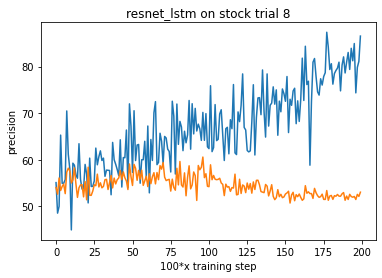

In [93]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock trial 8")
plt.xlabel("100*x training step")
plt.ylabel("precision")

In [91]:
#resnet_lstm trial 8 总结：稳定性和参数模型完全相同的trial5比要好一些
#下一步试验：增加l2正则化

In [94]:
#resnet_lstm trial 9
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 256  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 120
learning_rate = 0.001

device = torch.device("cuda:1")

In [95]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (drop): Dropout(p=0.7, inplace=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (drop): Dropout(p=0.7, inplace=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=Tru

In [98]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate, weight_decay=0.0001)

In [99]:
total_step=0
train_precision=[]
valid_precision=[]

In [102]:
total_step=0
for epoch in range(1000):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%100==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [1/120],step[100] Loss:0.5884
precision of the model on thetrainingdata: 68.0%
precision of the model on thevalidationdata: 55.65264892578125%
Epoch [2/120],step[200] Loss:0.5768
precision of the model on thetrainingdata: 71.07437896728516%
precision of the model on thevalidationdata: 54.09270095825195%
Epoch [2/120],step[300] Loss:0.5872
precision of the model on thetrainingdata: 70.53571319580078%
precision of the model on thevalidationdata: 54.93305206298828%
Epoch [3/120],step[400] Loss:0.6050
precision of the model on thetrainingdata: 65.13761138916016%
precision of the model on thevalidationdata: 57.11870193481445%
Epoch [3/120],step[500] Loss:0.5999
precision of the model on thetrainingdata: 59.25925827026367%
precision of the model on thevalidationdata: 56.422142028808594%
Epoch [4/120],step[600] Loss:0.6094
precision of the model on thetrainingdata: 71.92982482910156%
precision of the model on thevalidationdata: 56.058223724365234%
Epoch [5/120],step[700] Loss:0.5965
pre

precision of the model on thevalidationdata: 55.02489471435547%
Epoch [32/120],step[5200] Loss:0.5984
precision of the model on thetrainingdata: 62.90322494506836%
precision of the model on thevalidationdata: 53.363094329833984%
Epoch [32/120],step[5300] Loss:0.5856
precision of the model on thetrainingdata: 65.0%
precision of the model on thevalidationdata: 54.08567428588867%
Epoch [33/120],step[5400] Loss:0.5905
precision of the model on thetrainingdata: 65.18518829345703%
precision of the model on thevalidationdata: 53.62120056152344%
Epoch [33/120],step[5500] Loss:0.6054
precision of the model on thetrainingdata: 70.07874298095703%
precision of the model on thevalidationdata: 52.34946823120117%
Epoch [34/120],step[5600] Loss:0.5739
precision of the model on thetrainingdata: 58.67768478393555%
precision of the model on thevalidationdata: 54.32233428955078%
Epoch [35/120],step[5700] Loss:0.5801
precision of the model on thetrainingdata: 64.28571319580078%
precision of the model on th

Epoch [62/120],step[10200] Loss:0.6064
precision of the model on thetrainingdata: 68.22429656982422%
precision of the model on thevalidationdata: 52.065372467041016%
Epoch [62/120],step[10300] Loss:0.6066
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 53.18537902832031%
Epoch [63/120],step[10400] Loss:0.5272
precision of the model on thetrainingdata: 79.09091186523438%
precision of the model on thevalidationdata: 54.38559341430664%
Epoch [63/120],step[10500] Loss:0.5653
precision of the model on thetrainingdata: 74.31192779541016%
precision of the model on thevalidationdata: 51.72413635253906%
Epoch [64/120],step[10600] Loss:0.5871
precision of the model on thetrainingdata: 57.85123825073242%
precision of the model on thevalidationdata: 54.1902961730957%
Epoch [65/120],step[10700] Loss:0.5985
precision of the model on thetrainingdata: 57.85123825073242%
precision of the model on thevalidationdata: 53.20396041870117%
Epoch [65/

Epoch [92/120],step[15200] Loss:0.5924
precision of the model on thetrainingdata: 61.15702438354492%
precision of the model on thevalidationdata: 53.482540130615234%
Epoch [92/120],step[15300] Loss:0.6054
precision of the model on thetrainingdata: 69.81131744384766%
precision of the model on thevalidationdata: 52.97071075439453%
Epoch [93/120],step[15400] Loss:0.5807
precision of the model on thetrainingdata: 67.22689056396484%
precision of the model on thevalidationdata: 52.268775939941406%
Epoch [93/120],step[15500] Loss:0.6255
precision of the model on thetrainingdata: 70.4000015258789%
precision of the model on thevalidationdata: 52.545955657958984%
Epoch [94/120],step[15600] Loss:0.6226
precision of the model on thetrainingdata: 64.80000305175781%
precision of the model on thevalidationdata: 53.05124282836914%
Epoch [95/120],step[15700] Loss:0.5890
precision of the model on thetrainingdata: 61.744964599609375%
precision of the model on thevalidationdata: 51.94217300415039%
Epoch [

Epoch [121/120],step[20200] Loss:0.5878
precision of the model on thetrainingdata: 65.69342803955078%
precision of the model on thevalidationdata: 51.93465042114258%
Epoch [122/120],step[20300] Loss:0.5591
precision of the model on thetrainingdata: 72.26890563964844%
precision of the model on thevalidationdata: 52.29511642456055%
Epoch [123/120],step[20400] Loss:0.5694
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 51.843170166015625%
Epoch [123/120],step[20500] Loss:0.6647
precision of the model on thetrainingdata: 65.5999984741211%
precision of the model on thevalidationdata: 52.020835876464844%
Epoch [124/120],step[20600] Loss:0.6265
precision of the model on thetrainingdata: 64.34782409667969%
precision of the model on thevalidationdata: 51.973392486572266%
Epoch [124/120],step[20700] Loss:0.5927
precision of the model on thetrainingdata: 62.03703689575195%
precision of the model on thevalidationdata: 51.25871276855469%
Ep

Epoch [151/120],step[25200] Loss:0.5818
precision of the model on thetrainingdata: 62.5%
precision of the model on thevalidationdata: 51.93019485473633%
Epoch [152/120],step[25300] Loss:0.5144
precision of the model on thetrainingdata: 68.0412368774414%
precision of the model on thevalidationdata: 51.59221649169922%
Epoch [153/120],step[25400] Loss:0.5707
precision of the model on thetrainingdata: 65.76576232910156%
precision of the model on thevalidationdata: 53.05549240112305%
Epoch [153/120],step[25500] Loss:0.6122
precision of the model on thetrainingdata: 64.28571319580078%
precision of the model on thevalidationdata: 53.14126205444336%
Epoch [154/120],step[25600] Loss:0.5716
precision of the model on thetrainingdata: 65.64885711669922%
precision of the model on thevalidationdata: 53.48140335083008%
Epoch [154/120],step[25700] Loss:0.5451
precision of the model on thetrainingdata: 69.4214859008789%
precision of the model on thevalidationdata: 51.2918815612793%
Epoch [155/120],step

Epoch [181/120],step[30200] Loss:0.5784
precision of the model on thetrainingdata: 62.83185958862305%
precision of the model on thevalidationdata: 51.74119186401367%
Epoch [182/120],step[30300] Loss:0.5553
precision of the model on thetrainingdata: 74.0457992553711%
precision of the model on thevalidationdata: 52.34486770629883%
Epoch [183/120],step[30400] Loss:0.5993
precision of the model on thetrainingdata: 69.30693054199219%
precision of the model on thevalidationdata: 52.86846923828125%
Epoch [183/120],step[30500] Loss:0.5541
precision of the model on thetrainingdata: 65.4676284790039%
precision of the model on thevalidationdata: 52.695396423339844%
Epoch [184/120],step[30600] Loss:0.5688
precision of the model on thetrainingdata: 73.01587677001953%
precision of the model on thevalidationdata: 51.403743743896484%
Epoch [184/120],step[30700] Loss:0.5452
precision of the model on thetrainingdata: 74.10713958740234%
precision of the model on thevalidationdata: 51.92442321777344%
Epoc

precision of the model on thevalidationdata: 51.68501281738281%
Epoch [211/120],step[35200] Loss:0.5937
precision of the model on thetrainingdata: 65.0793685913086%
precision of the model on thevalidationdata: 51.634422302246094%
Epoch [212/120],step[35300] Loss:0.5900
precision of the model on thetrainingdata: 64.03508758544922%
precision of the model on thevalidationdata: 52.32245635986328%
Epoch [212/120],step[35400] Loss:0.5703
precision of the model on thetrainingdata: 65.54621887207031%
precision of the model on thevalidationdata: 51.81629943847656%
Epoch [213/120],step[35500] Loss:0.5194
precision of the model on thetrainingdata: 67.02127838134766%
precision of the model on thevalidationdata: 52.511417388916016%
Epoch [214/120],step[35600] Loss:0.5557
precision of the model on thetrainingdata: 71.32353210449219%
precision of the model on thevalidationdata: 52.682159423828125%
Epoch [214/120],step[35700] Loss:0.5552
precision of the model on thetrainingdata: 73.07691955566406%
pr

precision of the model on thevalidationdata: 52.376895904541016%
Epoch [241/120],step[40200] Loss:0.5759
precision of the model on thetrainingdata: 73.45132446289062%
precision of the model on thevalidationdata: 52.62696838378906%
Epoch [242/120],step[40300] Loss:0.5420
precision of the model on thetrainingdata: 76.10619354248047%
precision of the model on thevalidationdata: 52.444923400878906%
Epoch [242/120],step[40400] Loss:0.5575
precision of the model on thetrainingdata: 66.40625%
precision of the model on thevalidationdata: 52.962833404541016%
Epoch [243/120],step[40500] Loss:0.5603
precision of the model on thetrainingdata: 78.18181610107422%
precision of the model on thevalidationdata: 53.66127395629883%
Epoch [244/120],step[40600] Loss:0.5462
precision of the model on thetrainingdata: 67.82608795166016%
precision of the model on thevalidationdata: 52.919090270996094%
Epoch [244/120],step[40700] Loss:0.5710
precision of the model on thetrainingdata: 70.0%
precision of the model

precision of the model on thevalidationdata: 53.64130401611328%
Epoch [271/120],step[45200] Loss:0.6094
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 51.223426818847656%
Epoch [272/120],step[45300] Loss:0.6064
precision of the model on thetrainingdata: 66.98113250732422%
precision of the model on thevalidationdata: 52.308616638183594%
Epoch [272/120],step[45400] Loss:0.5675
precision of the model on thetrainingdata: 67.7966079711914%
precision of the model on thevalidationdata: 53.51010513305664%
Epoch [273/120],step[45500] Loss:0.5510
precision of the model on thetrainingdata: 69.04762268066406%
precision of the model on thevalidationdata: 52.774696350097656%
Epoch [274/120],step[45600] Loss:0.5788
precision of the model on thetrainingdata: 75.60975646972656%
precision of the model on thevalidationdata: 52.73908996582031%
Epoch [274/120],step[45700] Loss:0.5404
precision of the model on thetrainingdata: 73.21428680419922%
precision of th

precision of the model on thevalidationdata: 51.6278190612793%
Epoch [301/120],step[50200] Loss:0.5654
precision of the model on thetrainingdata: 75.9259262084961%
precision of the model on thevalidationdata: 52.55594253540039%
Epoch [302/120],step[50300] Loss:0.5720
precision of the model on thetrainingdata: 63.4782600402832%
precision of the model on thevalidationdata: 54.1089973449707%
Epoch [302/120],step[50400] Loss:0.5706
precision of the model on thetrainingdata: 69.72476959228516%
precision of the model on thevalidationdata: 51.66051483154297%
Epoch [303/120],step[50500] Loss:0.6169
precision of the model on thetrainingdata: 69.29824829101562%
precision of the model on thevalidationdata: 51.4133415222168%
Epoch [303/120],step[50600] Loss:0.5386
precision of the model on thetrainingdata: 71.42857360839844%
precision of the model on thevalidationdata: 51.62004470825195%
Epoch [304/120],step[50700] Loss:0.5663
precision of the model on thetrainingdata: 68.840576171875%
precision o

precision of the model on thevalidationdata: 52.00086975097656%
Epoch [331/120],step[55200] Loss:0.5298
precision of the model on thetrainingdata: 65.25423431396484%
precision of the model on thevalidationdata: 50.95193099975586%
Epoch [332/120],step[55300] Loss:0.5239
precision of the model on thetrainingdata: 77.68595123291016%
precision of the model on thevalidationdata: 51.121864318847656%
Epoch [332/120],step[55400] Loss:0.5533
precision of the model on thetrainingdata: 69.02655029296875%
precision of the model on thevalidationdata: 51.96434020996094%
Epoch [333/120],step[55500] Loss:0.5361
precision of the model on thetrainingdata: 80.0%
precision of the model on thevalidationdata: 52.63253402709961%
Epoch [333/120],step[55600] Loss:0.5680
precision of the model on thetrainingdata: 70.79646301269531%
precision of the model on thevalidationdata: 52.39765930175781%
Epoch [334/120],step[55700] Loss:0.6471
precision of the model on thetrainingdata: 68.85246276855469%
precision of the

precision of the model on thevalidationdata: 51.99324417114258%
Epoch [361/120],step[60200] Loss:0.5869
precision of the model on thetrainingdata: 69.56521606445312%
precision of the model on thevalidationdata: 52.3258171081543%
Epoch [362/120],step[60300] Loss:0.5473
precision of the model on thetrainingdata: 71.18643951416016%
precision of the model on thevalidationdata: 53.1985969543457%
Epoch [362/120],step[60400] Loss:0.5521
precision of the model on thetrainingdata: 74.80314636230469%
precision of the model on thevalidationdata: 51.45389938354492%
Epoch [363/120],step[60500] Loss:0.5563
precision of the model on thetrainingdata: 66.08695983886719%
precision of the model on thevalidationdata: 51.50316619873047%
Epoch [363/120],step[60600] Loss:0.4822
precision of the model on thetrainingdata: 76.42857360839844%
precision of the model on thevalidationdata: 50.883209228515625%
Epoch [364/120],step[60700] Loss:0.5855
precision of the model on thetrainingdata: 78.125%
precision of the

precision of the model on thevalidationdata: 52.33042907714844%
Epoch [391/120],step[65200] Loss:0.5735
precision of the model on thetrainingdata: 74.78260803222656%
precision of the model on thevalidationdata: 52.27223205566406%
Epoch [392/120],step[65300] Loss:0.5780
precision of the model on thetrainingdata: 65.83333587646484%
precision of the model on thevalidationdata: 50.993377685546875%
Epoch [392/120],step[65400] Loss:0.5523
precision of the model on thetrainingdata: 72.26890563964844%
precision of the model on thevalidationdata: 51.61956024169922%
Epoch [393/120],step[65500] Loss:0.5952
precision of the model on thetrainingdata: 60.15625%
precision of the model on thevalidationdata: 52.993961334228516%
Epoch [393/120],step[65600] Loss:0.5279
precision of the model on thetrainingdata: 75.20661163330078%
precision of the model on thevalidationdata: 50.98109817504883%
Epoch [394/120],step[65700] Loss:0.5678
precision of the model on thetrainingdata: 79.3388442993164%
precision of

precision of the model on thevalidationdata: 51.82154846191406%
Epoch [421/120],step[70200] Loss:0.5755
precision of the model on thetrainingdata: 69.56521606445312%
precision of the model on thevalidationdata: 50.825592041015625%
Epoch [421/120],step[70300] Loss:0.5374
precision of the model on thetrainingdata: 69.7479019165039%
precision of the model on thevalidationdata: 51.9267463684082%
Epoch [422/120],step[70400] Loss:0.5245
precision of the model on thetrainingdata: 77.06421661376953%
precision of the model on thevalidationdata: 51.7059211730957%
Epoch [423/120],step[70500] Loss:0.5382
precision of the model on thetrainingdata: 71.81818389892578%
precision of the model on thevalidationdata: 50.653594970703125%
Epoch [423/120],step[70600] Loss:0.5410
precision of the model on thetrainingdata: 77.03704071044922%
precision of the model on thevalidationdata: 51.45610427856445%
Epoch [424/120],step[70700] Loss:0.5176
precision of the model on thetrainingdata: 75.75757598876953%
preci

precision of the model on thevalidationdata: 52.234554290771484%
Epoch [451/120],step[75200] Loss:0.5113
precision of the model on thetrainingdata: 71.21212005615234%
precision of the model on thevalidationdata: 51.58616256713867%
Epoch [451/120],step[75300] Loss:0.5633
precision of the model on thetrainingdata: 76.41509246826172%
precision of the model on thevalidationdata: 52.553043365478516%
Epoch [452/120],step[75400] Loss:0.5150
precision of the model on thetrainingdata: 78.84615325927734%
precision of the model on thevalidationdata: 52.51325988769531%
Epoch [453/120],step[75500] Loss:0.5492
precision of the model on thetrainingdata: 72.64957427978516%
precision of the model on thevalidationdata: 51.33208084106445%
Epoch [453/120],step[75600] Loss:0.5407
precision of the model on thetrainingdata: 69.81131744384766%
precision of the model on thevalidationdata: 52.189781188964844%
Epoch [454/120],step[75700] Loss:0.5425
precision of the model on thetrainingdata: 71.21212005615234%
p

Epoch [480/120],step[80100] Loss:0.5596
precision of the model on thetrainingdata: 72.13114929199219%
precision of the model on thevalidationdata: 51.99237823486328%
Epoch [481/120],step[80200] Loss:0.5554
precision of the model on thetrainingdata: 69.16666412353516%
precision of the model on thevalidationdata: 52.73092269897461%
Epoch [481/120],step[80300] Loss:0.5250
precision of the model on thetrainingdata: 76.31578826904297%
precision of the model on thevalidationdata: 51.980716705322266%
Epoch [482/120],step[80400] Loss:0.5366
precision of the model on thetrainingdata: 71.02803802490234%
precision of the model on thevalidationdata: 50.69721221923828%
Epoch [483/120],step[80500] Loss:0.5508
precision of the model on thetrainingdata: 74.79674530029297%
precision of the model on thevalidationdata: 50.45672607421875%
Epoch [483/120],step[80600] Loss:0.5480
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 53.47024154663086%
Epoch [484/120],

precision of the model on thevalidationdata: 51.550655364990234%
Epoch [510/120],step[85100] Loss:0.5356
precision of the model on thetrainingdata: 72.58064270019531%
precision of the model on thevalidationdata: 51.04673385620117%
Epoch [511/120],step[85200] Loss:0.5534
precision of the model on thetrainingdata: 65.625%
precision of the model on thevalidationdata: 52.03806686401367%
Epoch [511/120],step[85300] Loss:0.4650
precision of the model on thetrainingdata: 80.70175170898438%
precision of the model on thevalidationdata: 52.28215789794922%
Epoch [512/120],step[85400] Loss:0.5266
precision of the model on thetrainingdata: 71.19999694824219%
precision of the model on thevalidationdata: 52.95545196533203%
Epoch [512/120],step[85500] Loss:0.4978
precision of the model on thetrainingdata: 68.37606811523438%
precision of the model on thevalidationdata: 52.73124694824219%
Epoch [513/120],step[85600] Loss:0.5641
precision of the model on thetrainingdata: 65.4676284790039%
precision of th

precision of the model on thevalidationdata: 51.52994155883789%
Epoch [540/120],step[90100] Loss:0.5365
precision of the model on thetrainingdata: 74.10071563720703%
precision of the model on thevalidationdata: 51.97356033325195%
Epoch [541/120],step[90200] Loss:0.5278
precision of the model on thetrainingdata: 70.3125%
precision of the model on thevalidationdata: 50.90768814086914%
Epoch [541/120],step[90300] Loss:0.5389
precision of the model on thetrainingdata: 67.24137878417969%
precision of the model on thevalidationdata: 52.89290237426758%
Epoch [542/120],step[90400] Loss:0.5468
precision of the model on thetrainingdata: 80.90908813476562%
precision of the model on thevalidationdata: 52.346500396728516%
Epoch [542/120],step[90500] Loss:0.5325
precision of the model on thetrainingdata: 73.10924530029297%
precision of the model on thevalidationdata: 51.15446472167969%
Epoch [543/120],step[90600] Loss:0.5101
precision of the model on thetrainingdata: 75.0%
precision of the model on 

precision of the model on thevalidationdata: 52.20905303955078%
Epoch [570/120],step[95100] Loss:0.5794
precision of the model on thetrainingdata: 74.54545593261719%
precision of the model on thevalidationdata: 52.8931884765625%
Epoch [571/120],step[95200] Loss:0.5232
precision of the model on thetrainingdata: 80.80000305175781%
precision of the model on thevalidationdata: 51.39244842529297%
Epoch [571/120],step[95300] Loss:0.5385
precision of the model on thetrainingdata: 68.80734252929688%
precision of the model on thevalidationdata: 51.746395111083984%
Epoch [572/120],step[95400] Loss:0.5354
precision of the model on thetrainingdata: 76.7676773071289%
precision of the model on thevalidationdata: 51.399330139160156%
Epoch [572/120],step[95500] Loss:0.5188
precision of the model on thetrainingdata: 78.03030395507812%
precision of the model on thevalidationdata: 51.2635383605957%
Epoch [573/120],step[95600] Loss:0.5755
precision of the model on thetrainingdata: 66.66666412353516%
preci

precision of the model on thevalidationdata: 51.366119384765625%
Epoch [600/120],step[100100] Loss:0.4695
precision of the model on thetrainingdata: 77.11864471435547%
precision of the model on thevalidationdata: 51.162349700927734%
Epoch [600/120],step[100200] Loss:0.4993
precision of the model on thetrainingdata: 81.25%
precision of the model on thevalidationdata: 51.46281433105469%
Epoch [601/120],step[100300] Loss:0.5171
precision of the model on thetrainingdata: 77.68595123291016%
precision of the model on thevalidationdata: 51.14931869506836%
Epoch [602/120],step[100400] Loss:0.5292
precision of the model on thetrainingdata: 70.94017028808594%
precision of the model on thevalidationdata: 50.917701721191406%
Epoch [602/120],step[100500] Loss:0.5388
precision of the model on thetrainingdata: 73.5042724609375%
precision of the model on thevalidationdata: 52.42155456542969%
Epoch [603/120],step[100600] Loss:0.5687
precision of the model on thetrainingdata: 70.86614227294922%
precisio

Epoch [629/120],step[105000] Loss:0.5481
precision of the model on thetrainingdata: 74.54545593261719%
precision of the model on thevalidationdata: 52.64602279663086%
Epoch [630/120],step[105100] Loss:0.5202
precision of the model on thetrainingdata: 71.79486846923828%
precision of the model on thevalidationdata: 51.51567459106445%
Epoch [630/120],step[105200] Loss:0.5078
precision of the model on thetrainingdata: 74.10713958740234%
precision of the model on thevalidationdata: 51.771549224853516%
Epoch [631/120],step[105300] Loss:0.5469
precision of the model on thetrainingdata: 66.39344024658203%
precision of the model on thevalidationdata: 51.221595764160156%
Epoch [632/120],step[105400] Loss:0.5475
precision of the model on thetrainingdata: 74.5614013671875%
precision of the model on thevalidationdata: 51.79063415527344%
Epoch [632/120],step[105500] Loss:0.4936
precision of the model on thetrainingdata: 74.54545593261719%
precision of the model on thevalidationdata: 50.4543151855468

precision of the model on thevalidationdata: 52.23850631713867%
Epoch [659/120],step[110000] Loss:0.5506
precision of the model on thetrainingdata: 59.82905960083008%
precision of the model on thevalidationdata: 51.4074821472168%
Epoch [660/120],step[110100] Loss:0.4838
precision of the model on thetrainingdata: 81.81818389892578%
precision of the model on thevalidationdata: 51.95721435546875%
Epoch [660/120],step[110200] Loss:0.5601
precision of the model on thetrainingdata: 72.22222137451172%
precision of the model on thevalidationdata: 51.05927658081055%
Epoch [661/120],step[110300] Loss:0.5073
precision of the model on thetrainingdata: 77.94117736816406%
precision of the model on thevalidationdata: 51.50034713745117%
Epoch [662/120],step[110400] Loss:0.5279
precision of the model on thetrainingdata: 72.0%
precision of the model on thevalidationdata: 53.31983947753906%
Epoch [662/120],step[110500] Loss:0.5644
precision of the model on thetrainingdata: 74.19355010986328%
precision of

precision of the model on thevalidationdata: 51.96932601928711%
Epoch [689/120],step[115000] Loss:0.5308
precision of the model on thetrainingdata: 76.52173614501953%
precision of the model on thevalidationdata: 51.14503860473633%
Epoch [690/120],step[115100] Loss:0.5665
precision of the model on thetrainingdata: 77.5700912475586%
precision of the model on thevalidationdata: 52.19287109375%
Epoch [690/120],step[115200] Loss:0.4563
precision of the model on thetrainingdata: 79.46428680419922%
precision of the model on thevalidationdata: 51.94140625%
Epoch [691/120],step[115300] Loss:0.5352
precision of the model on thetrainingdata: 79.77528381347656%
precision of the model on thevalidationdata: 51.76039123535156%
Epoch [692/120],step[115400] Loss:0.5596
precision of the model on thetrainingdata: 75.19999694824219%
precision of the model on thevalidationdata: 50.20746994018555%
Epoch [692/120],step[115500] Loss:0.5295
precision of the model on thetrainingdata: 77.23577117919922%
precisio

Epoch [718/120],step[119900] Loss:0.5624
precision of the model on thetrainingdata: 70.4000015258789%
precision of the model on thevalidationdata: 51.42683792114258%
Epoch [719/120],step[120000] Loss:0.5085
precision of the model on thetrainingdata: 70.71428680419922%
precision of the model on thevalidationdata: 51.32112121582031%
Epoch [720/120],step[120100] Loss:0.5799
precision of the model on thetrainingdata: 68.6440658569336%
precision of the model on thevalidationdata: 51.60841751098633%
Epoch [720/120],step[120200] Loss:0.5200
precision of the model on thetrainingdata: 78.04878234863281%
precision of the model on thevalidationdata: 51.1646728515625%
Epoch [721/120],step[120300] Loss:0.4877
precision of the model on thetrainingdata: 76.42276763916016%
precision of the model on thevalidationdata: 52.15778350830078%
Epoch [721/120],step[120400] Loss:0.5612
precision of the model on thetrainingdata: 69.918701171875%
precision of the model on thevalidationdata: 51.749176025390625%
Ep

precision of the model on thevalidationdata: 51.73065948486328%
Epoch [748/120],step[124900] Loss:0.4998
precision of the model on thetrainingdata: 77.11864471435547%
precision of the model on thevalidationdata: 51.51900863647461%
Epoch [749/120],step[125000] Loss:0.5675
precision of the model on thetrainingdata: 67.37588500976562%
precision of the model on thevalidationdata: 51.61940002441406%
Epoch [750/120],step[125100] Loss:0.5418
precision of the model on thetrainingdata: 73.77049255371094%
precision of the model on thevalidationdata: 52.427001953125%
Epoch [750/120],step[125200] Loss:0.4981
precision of the model on thetrainingdata: 75.4385986328125%
precision of the model on thevalidationdata: 52.07381820678711%
Epoch [751/120],step[125300] Loss:0.5058
precision of the model on thetrainingdata: 75.86206817626953%
precision of the model on thevalidationdata: 52.61117935180664%
Epoch [751/120],step[125400] Loss:0.5239
precision of the model on thetrainingdata: 66.93548583984375%
p

Epoch [778/120],step[129800] Loss:0.4803
precision of the model on thetrainingdata: 84.03361511230469%
precision of the model on thevalidationdata: 51.66387939453125%
Epoch [778/120],step[129900] Loss:0.5034
precision of the model on thetrainingdata: 77.77777862548828%
precision of the model on thevalidationdata: 52.60695266723633%
Epoch [779/120],step[130000] Loss:0.5233
precision of the model on thetrainingdata: 81.73076629638672%
precision of the model on thevalidationdata: 52.07461166381836%
Epoch [780/120],step[130100] Loss:0.5159
precision of the model on thetrainingdata: 72.0%
precision of the model on thevalidationdata: 53.375694274902344%
Epoch [780/120],step[130200] Loss:0.5253
precision of the model on thetrainingdata: 80.62015533447266%
precision of the model on thevalidationdata: 51.67133331298828%
Epoch [781/120],step[130300] Loss:0.5358
precision of the model on thetrainingdata: 78.125%
precision of the model on thevalidationdata: 52.04063415527344%
Epoch [781/120],step[

precision of the model on thevalidationdata: 51.86269760131836%
Epoch [808/120],step[134800] Loss:0.5230
precision of the model on thetrainingdata: 74.766357421875%
precision of the model on thevalidationdata: 51.567806243896484%
Epoch [808/120],step[134900] Loss:0.5210
precision of the model on thetrainingdata: 76.11940002441406%
precision of the model on thevalidationdata: 52.24892044067383%
Epoch [809/120],step[135000] Loss:0.5666
precision of the model on thetrainingdata: 72.0%
precision of the model on thevalidationdata: 53.10307693481445%
Epoch [809/120],step[135100] Loss:0.5064
precision of the model on thetrainingdata: 76.66666412353516%
precision of the model on thevalidationdata: 52.39616775512695%
Epoch [810/120],step[135200] Loss:0.5228
precision of the model on thetrainingdata: 73.72262573242188%
precision of the model on thevalidationdata: 52.40788269042969%
Epoch [811/120],step[135300] Loss:0.5695
precision of the model on thetrainingdata: 77.31092071533203%
precision of

precision of the model on thevalidationdata: 51.35852813720703%
Epoch [838/120],step[139800] Loss:0.5093
precision of the model on thetrainingdata: 75.34246826171875%
precision of the model on thevalidationdata: 51.844696044921875%
Epoch [838/120],step[139900] Loss:0.5721
precision of the model on thetrainingdata: 76.63551330566406%
precision of the model on thevalidationdata: 51.66447830200195%
Epoch [839/120],step[140000] Loss:0.5307
precision of the model on thetrainingdata: 74.0740737915039%
precision of the model on thevalidationdata: 52.41691970825195%
Epoch [839/120],step[140100] Loss:0.5161
precision of the model on thetrainingdata: 78.74015808105469%
precision of the model on thevalidationdata: 51.89851379394531%
Epoch [840/120],step[140200] Loss:0.5342
precision of the model on thetrainingdata: 70.0%
precision of the model on thevalidationdata: 52.022090911865234%
Epoch [841/120],step[140300] Loss:0.5202
precision of the model on thetrainingdata: 70.0%
precision of the model 

Epoch [867/120],step[144700] Loss:0.5168
precision of the model on thetrainingdata: 75.4237289428711%
precision of the model on thevalidationdata: 52.43124771118164%
Epoch [868/120],step[144800] Loss:0.5736
precision of the model on thetrainingdata: 73.5042724609375%
precision of the model on thevalidationdata: 51.38888931274414%
Epoch [868/120],step[144900] Loss:0.5262
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 51.60581588745117%
Epoch [869/120],step[145000] Loss:0.5057
precision of the model on thetrainingdata: 73.55371856689453%
precision of the model on thevalidationdata: 51.73419952392578%
Epoch [869/120],step[145100] Loss:0.5185
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 50.9595832824707%
Epoch [870/120],step[145200] Loss:0.5615
precision of the model on thetrainingdata: 74.16666412353516%
precision of the model on thevalidationdata: 51.88800811767578%
Epoch [871/120],step[145300

precision of the model on thevalidationdata: 51.9185791015625%
Epoch [897/120],step[149700] Loss:0.5031
precision of the model on thetrainingdata: 77.69230651855469%
precision of the model on thevalidationdata: 52.17316436767578%
Epoch [898/120],step[149800] Loss:0.5271
precision of the model on thetrainingdata: 75.75757598876953%
precision of the model on thevalidationdata: 51.55754470825195%
Epoch [898/120],step[149900] Loss:0.5479
precision of the model on thetrainingdata: 71.81818389892578%
precision of the model on thevalidationdata: 51.60493850708008%
Epoch [899/120],step[150000] Loss:0.5601
precision of the model on thetrainingdata: 72.7272720336914%
precision of the model on thevalidationdata: 51.236045837402344%
Epoch [899/120],step[150100] Loss:0.5384
precision of the model on thetrainingdata: 73.91304016113281%
precision of the model on thevalidationdata: 51.25142288208008%
Epoch [900/120],step[150200] Loss:0.5318
precision of the model on thetrainingdata: 76.69172668457031%

precision of the model on thevalidationdata: 51.73465347290039%
Epoch [927/120],step[154700] Loss:0.5169
precision of the model on thetrainingdata: 79.67479705810547%
precision of the model on thevalidationdata: 52.20687484741211%
Epoch [927/120],step[154800] Loss:0.5468
precision of the model on thetrainingdata: 65.95744323730469%
precision of the model on thevalidationdata: 51.27417755126953%
Epoch [928/120],step[154900] Loss:0.5310
precision of the model on thetrainingdata: 78.63247680664062%
precision of the model on thevalidationdata: 50.333465576171875%
Epoch [929/120],step[155000] Loss:0.5136
precision of the model on thetrainingdata: 78.33333587646484%
precision of the model on thevalidationdata: 51.78476333618164%
Epoch [929/120],step[155100] Loss:0.4972
precision of the model on thetrainingdata: 75.70093536376953%
precision of the model on thevalidationdata: 51.774635314941406%
Epoch [930/120],step[155200] Loss:0.5456
precision of the model on thetrainingdata: 70.476188659667

Epoch [956/120],step[159600] Loss:0.6390
precision of the model on thetrainingdata: 72.65625%
precision of the model on thevalidationdata: 51.739925384521484%
Epoch [957/120],step[159700] Loss:0.5219
precision of the model on thetrainingdata: 75.78125%
precision of the model on thevalidationdata: 52.1180305480957%
Epoch [957/120],step[159800] Loss:0.4973
precision of the model on thetrainingdata: 78.04878234863281%
precision of the model on thevalidationdata: 51.02873229980469%
Epoch [958/120],step[159900] Loss:0.5529
precision of the model on thetrainingdata: 72.86821746826172%
precision of the model on thevalidationdata: 51.70454406738281%
Epoch [959/120],step[160000] Loss:0.6582
precision of the model on thetrainingdata: 60.162601470947266%
precision of the model on thevalidationdata: 51.598175048828125%
Epoch [959/120],step[160100] Loss:0.6431
precision of the model on thetrainingdata: 65.3465347290039%
precision of the model on thevalidationdata: 54.11683654785156%
Epoch [960/120]

precision of the model on thevalidationdata: 50.632911682128906%
Epoch [986/120],step[164600] Loss:0.5240
precision of the model on thetrainingdata: 78.41726684570312%
precision of the model on thevalidationdata: 51.191650390625%
Epoch [987/120],step[164700] Loss:0.4945
precision of the model on thetrainingdata: 83.33333587646484%
precision of the model on thevalidationdata: 51.60956954956055%
Epoch [987/120],step[164800] Loss:0.5100
precision of the model on thetrainingdata: 75.21367645263672%
precision of the model on thevalidationdata: 52.52404022216797%
Epoch [988/120],step[164900] Loss:0.5196
precision of the model on thetrainingdata: 79.86576843261719%
precision of the model on thevalidationdata: 51.876190185546875%
Epoch [989/120],step[165000] Loss:0.5224
precision of the model on thetrainingdata: 73.73737335205078%
precision of the model on thevalidationdata: 51.179840087890625%
Epoch [989/120],step[165100] Loss:0.5416
precision of the model on thetrainingdata: 69.4214859008789

In [183]:
m=np.load("sum_train_precision.npy",allow_pickle=True)
#k=np.load("sum_train_precision.npy")

In [186]:
a=m.tolist()
a.extend(a)

[tensor(74.4292, device='cuda:1'),
 tensor(74.8691, device='cuda:1'),
 tensor(86.2434, device='cuda:1'),
 tensor(83.6634, device='cuda:1'),
 tensor(89.6341, device='cuda:1'),
 tensor(92.4528, device='cuda:1'),
 tensor(92.3077, device='cuda:1'),
 tensor(95.8824, device='cuda:1'),
 tensor(93.1250, device='cuda:1'),
 tensor(93.7853, device='cuda:1'),
 tensor(95.6757, device='cuda:1'),
 tensor(92.1053, device='cuda:1'),
 tensor(99.3464, device='cuda:1'),
 tensor(98.5507, device='cuda:1'),
 tensor(92.7461, device='cuda:1'),
 tensor(94.1520, device='cuda:1')]

In [154]:
c,b

([[2]], [[2]])

In [164]:
a=[1,2,3]

In [165]:
b=[]

In [166]:
c=a+b

In [167]:
c=c+a

In [168]:
c

[1, 2, 3, 1, 2, 3]

In [163]:
c[1]

1

In [182]:
b=[]
a=[[1,2,3],[1,2,3]]
len(a)
b.extend(a[1])
b

[1, 2, 3]

[tensor(74.4292, device='cuda:1'), tensor(74.8691, device='cuda:1'), tensor(86.2434, device='cuda:1'), tensor(83.6634, device='cuda:1'), tensor(89.6341, device='cuda:1'), tensor(92.4528, device='cuda:1'), tensor(92.3077, device='cuda:1'), tensor(95.8824, device='cuda:1'), tensor(93.1250, device='cuda:1'), tensor(93.7853, device='cuda:1'), tensor(95.6757, device='cuda:1'), tensor(92.1053, device='cuda:1'), tensor(99.3464, device='cuda:1'), tensor(98.5507, device='cuda:1'), tensor(92.7461, device='cuda:1'), tensor(94.1520, device='cuda:1')] [tensor(74.4292, device='cuda:1'), tensor(74.8691, device='cuda:1'), tensor(86.2434, device='cuda:1'), tensor(83.6634, device='cuda:1'), tensor(89.6341, device='cuda:1'), tensor(92.4528, device='cuda:1'), tensor(92.3077, device='cuda:1'), tensor(95.8824, device='cuda:1'), tensor(93.1250, device='cuda:1'), tensor(93.7853, device='cuda:1'), tensor(95.6757, device='cuda:1'), tensor(92.1053, device='cuda:1'), tensor(99.3464, device='cuda:1'), tensor(98.55

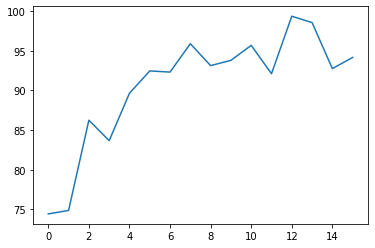

In [191]:
print(*a)
plt.plot(*(m.tolist()))